### Libraries

In [4]:
import torch
import pandas as pd
# import torchvision
import numpy as np
%matplotlib inline
import skimage.io as io
import matplotlib.pyplot as plt
import csv
from tqdm.auto import tqdm
from loader import FlickrDataset,preprocessing_transforms,get_data_loader,denormalize,Padding
from vocab import Vocabulary
from model import EncoderCNN,DecoderRNN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.utils.data import DataLoader


In [1]:
# import sys
# del sys.modules["loader"]

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Building Vocabulary and Loading our data


In [6]:
vocab = Vocabulary()

In [7]:
vocab.build_vocab()

In [8]:
vocab.save_vocab()

In [9]:
train_data = FlickrDataset('flickr30k_processed/train.csv', vocab = vocab,images_folder='flickr30k_processed/images', transform=preprocessing_transforms())

/Users/nadia/opt/anaconda3/envs/adlproject/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [7]:
# train_loader = DataLoader(dataset=train_data
#                           , batch_size= 32,
#                           num_workers=3,pin_memory=True, shuffle=True,  collate_fn= Padding(pad_idx=0,batch_first=True))
#


In [10]:
train_loader = get_data_loader(train_data, batch_size = 32,pad_index=0)

18


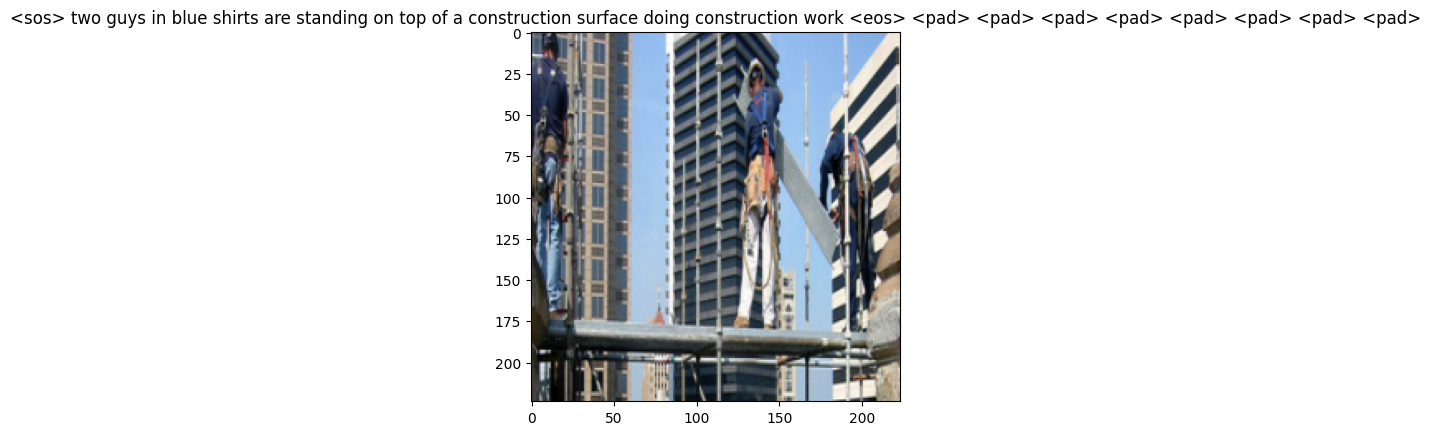

11


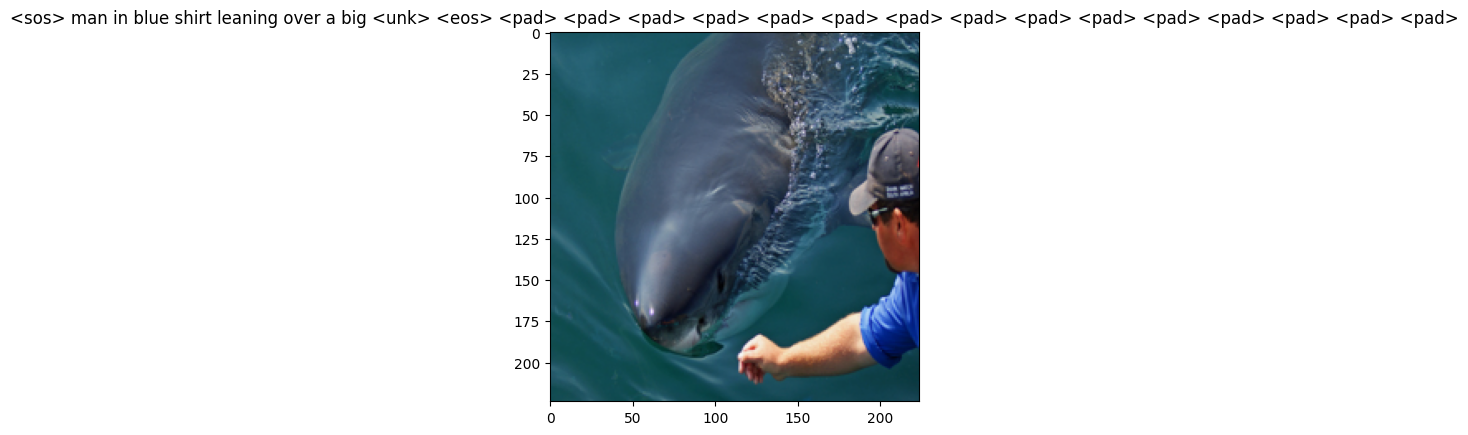

8


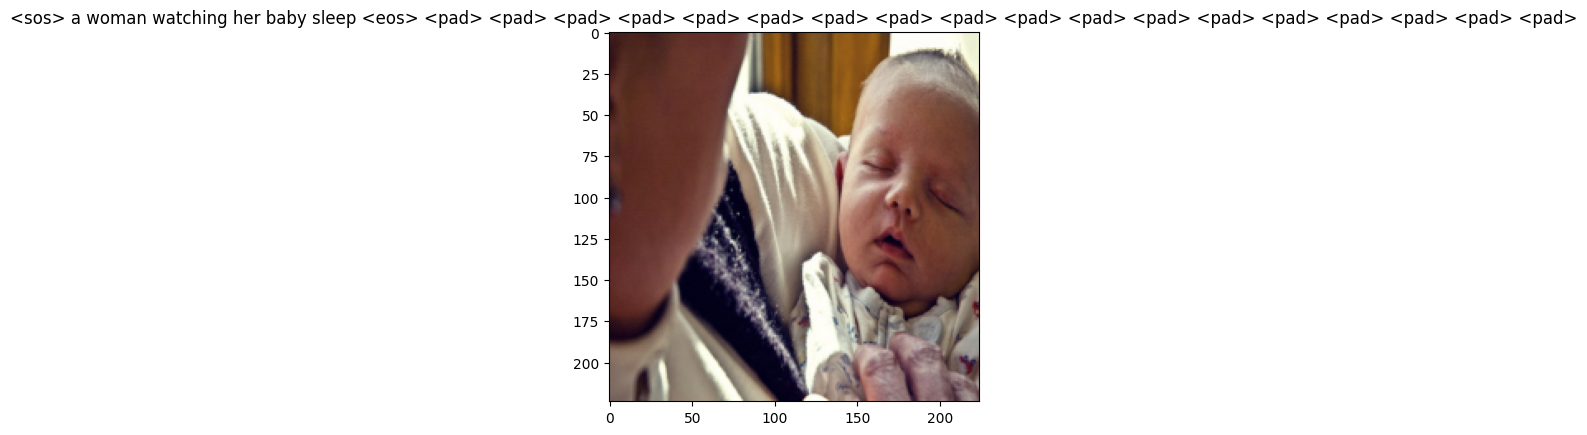

9


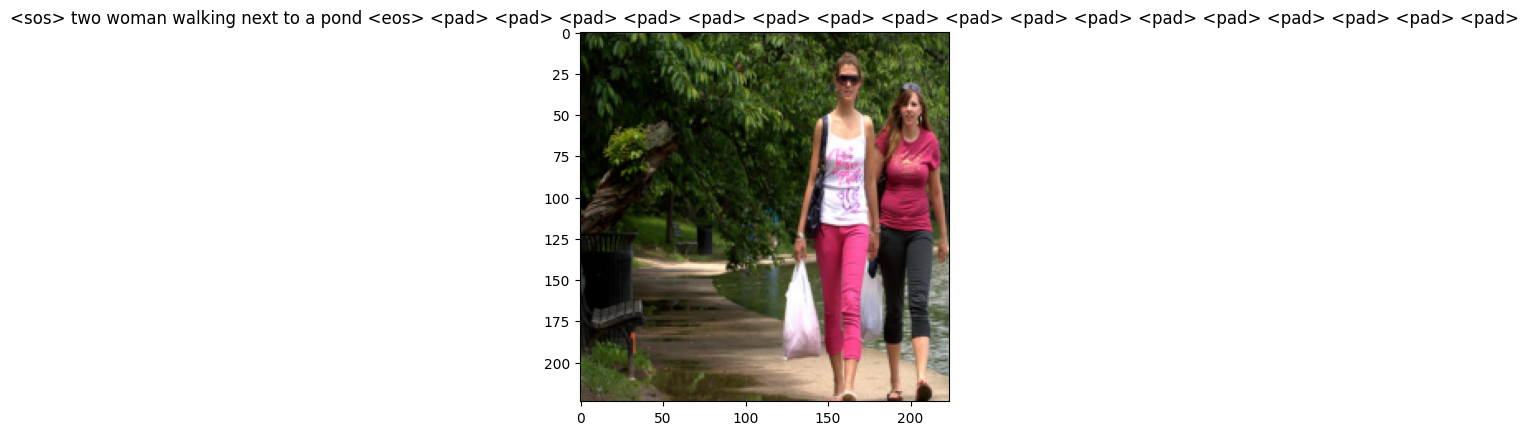

16


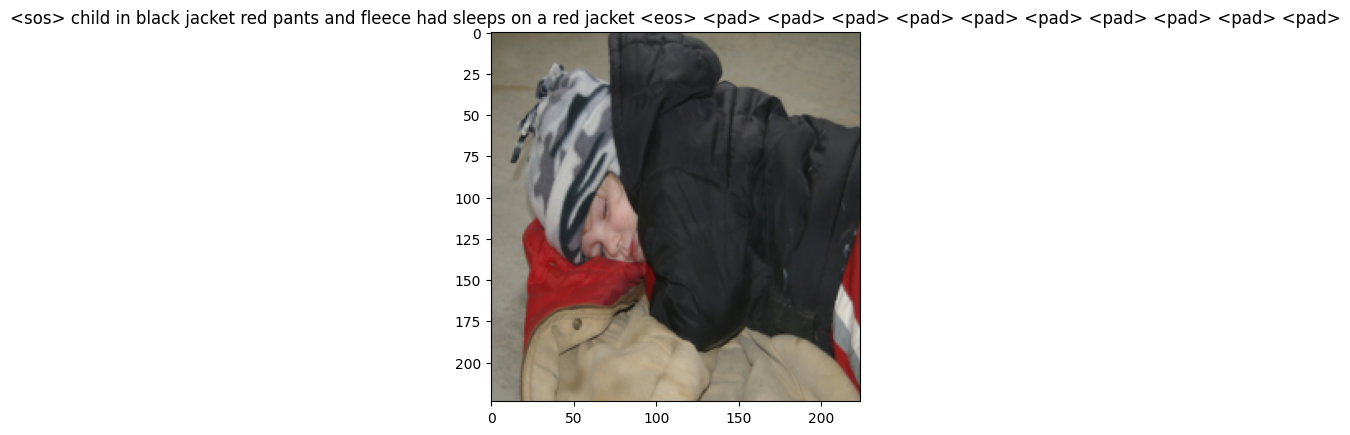

In [10]:
#looking at first 5 images & captions
i= 0
x, y,l = next(iter(train_loader))
for image, caption,length in zip(x, y,l):
    image = denormalize(image)
    caption = [vocab.idx_to_word(int(word_id)) for word_id in caption]
    caption = ' '.join(word for word in caption)
    plt.imshow(image)
    plt.title(caption)
    print(length)
    plt.show()
    plt.pause(1)
    i+=1
    if i ==5:
        break

### Model

In [11]:
encoder = EncoderCNN(embed_size=512,device = device).to(device)

In [12]:
decoder = DecoderRNN(embed_size = 512, hidden_size =1024,vocab_size =  5000,num_layers=1,max_seq_length=20).to(device)


In [13]:
criterion = torch.nn.CrossEntropyLoss()
parameters = list(decoder.parameters())  + list(encoder.linear.parameters()) + list(encoder.bn.parameters())

In [14]:

optimizer = torch.optim.Adam(params=parameters, lr= 0.001)

### Training my model

In [15]:
total_steps = len(train_loader)

In [16]:
total_steps

4532

In [17]:
from torch.nn.utils.rnn import pack_padded_sequence


In [20]:
best_bleu4 = -100
no_improvement = 0
patience = 3
early_stopper = False
for epoch in range(3):
    train_loss = []
    val_loss = []
    predictions = []
    references = []

    for images,captions,lengths in tqdm(train_loader):
        encoder.train()
        decoder.train()
        images = images.to(device)
        captions = captions.to(device)
        targets = pack_padded_sequence(captions, lengths, batch_first=True,enforce_sorted=False)[0]

        #forward, backward and optimization
        features = encoder(images)
        outputs = decoder(features,captions,lengths)
        t_loss = criterion(outputs,targets)

        t_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss.append(t_loss.item())


    with torch.no_grad():
        for images,captions,lengths in tqdm(val_loader):
            encoder.eval()
            decoder.eval()

            images = images.to(device)
            captions = captions.to(device)
            lengths = lengths.to(device)
            features = encoder(image)
            targets = pack_padded_sequence(captions, lengths, batch_first=True,enforce_sorted=False)[0]
            decoder(features,captions,lengths)
            v_loss = criterion(outputs,targets)

            hypotheses_ids = decoder.sample(features)
            hypotheses_ids = hypotheses_ids[0].cpu().numpy()


            # Convert word_ids to words
            sampled_caption = []
            for word_id in hypotheses_ids:
                word = vocab.idx_to_word[word_id]
                sampled_caption.append(word)
                if word == '<end>':
                    break
            sentence = ' '.join(sampled_caption)

            val_loss.append(v_loss)
            predictions.append(predictions)
            references.append(targets)

    bleu4 = corpus_bleu(references, predictions)
    print(f'Epoch {epoch +1} Train Loss : {np.mean(train_loss)} ')
    print(f'Epoch {epoch +1} Validation Loss : {np.mean(val_loss)} , BLEU Score {bleu4} ')

    if bleu4 > best_bleu4:
        torch.save(encoder.state_dict(), encoder_model)
        torch.save(decoder.state_dict(),decoder_model)
        best_bleu4 = bleu4
        no_improvement = 0
    else:
        no_improvement +=1

    if no_improvement >= patience:
        early_stopper = True
        print(f'Triggering early stopping at epoch {epoch+1}')
        break


KeyboardInterrupt: 